In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score, 
                             recall_score, f1_score, confusion_matrix, 
                             classification_report, roc_curve)
import xgboost as xgb
import pickle
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

In [6]:
df = pd.read_csv('online_shoppers_intention.csv')

print(f"Dataset: {df.shape[0]:,} sessions, {df.shape[1]} features")
df.head()

Dataset: 12,330 sessions, 18 features


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


#### Data exploration

In [9]:
# Check data info
print(df.info())
print()
print(df.isnull().sum())
print()
print(df.dtypes)
print()

df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


#### EDA steps

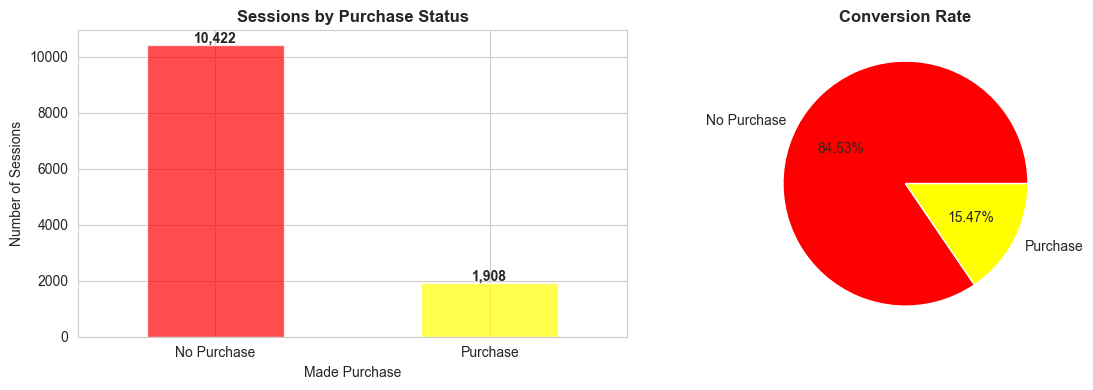

   No Purchase: (84.53%)
   Purchase: (15.47%)


In [13]:
# Analyze purchase conversion
conversion = df['Revenue'].value_counts()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))


conversion.plot(kind='bar', ax=axes[0], color=['red', 'yellow'], alpha=0.7)
axes[0].set_title('Sessions by Purchase Status', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Made Purchase')
axes[0].set_ylabel('Number of Sessions')
axes[0].set_xticklabels(['No Purchase', 'Purchase'], rotation=0)

# Add counts on bars
for i, v in enumerate(conversion.values):
    axes[0].text(i, v + 100, f'{v:,}', ha='center', fontweight='bold')

conversion.plot(kind='pie', ax=axes[1], autopct='%1.2f%%', 
                colors=['red', 'yellow'], labels=['No Purchase', 'Purchase'])
axes[1].set_ylabel('')
axes[1].set_title('Conversion Rate', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.show()

conversion_rate = df['Revenue'].mean()
print(f"   No Purchase: ({conversion[False]/len(df)*100:.2f}%)")
print(f"   Purchase: ({conversion[True]/len(df)*100:.2f}%)")

#### EDA - Numerical Features Distribution

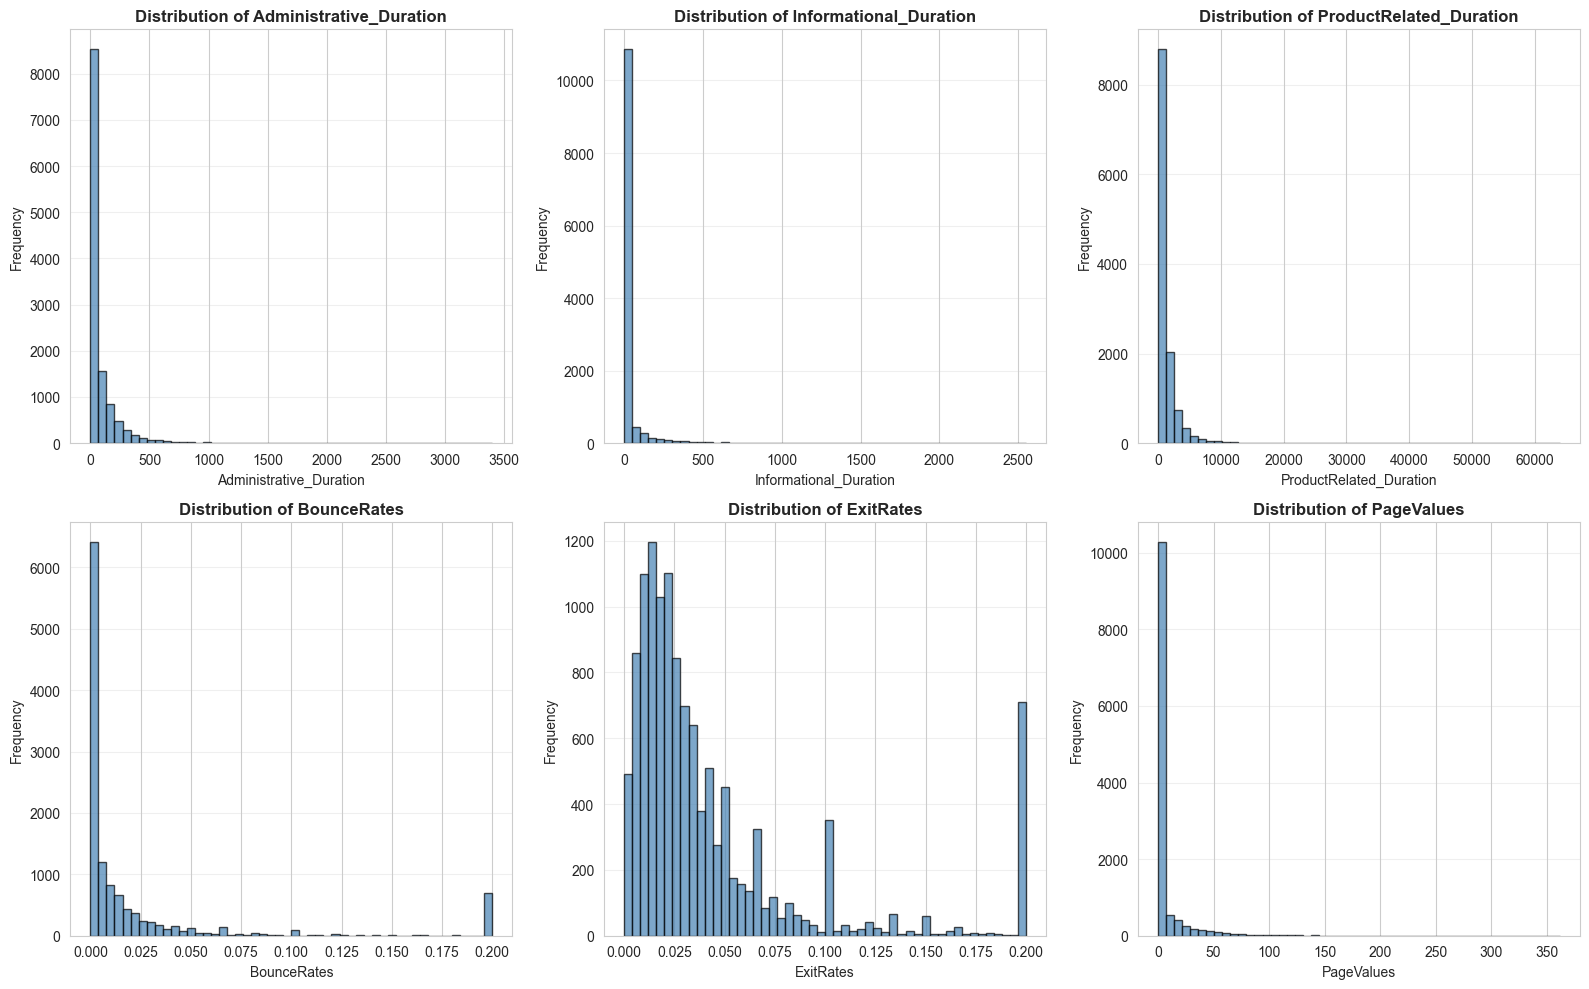

Numerical features summary:
       Administrative_Duration  Informational_Duration  \
count             12330.000000            12330.000000   
mean                 80.818611               34.472398   
std                 176.779107              140.749294   
min                   0.000000                0.000000   
25%                   0.000000                0.000000   
50%                   7.500000                0.000000   
75%                  93.256250                0.000000   
max                3398.750000             2549.375000   

       ProductRelated_Duration   BounceRates     ExitRates    PageValues  
count             12330.000000  12330.000000  12330.000000  12330.000000  
mean               1194.746220      0.022191      0.043073      5.889258  
std                1913.669288      0.048488      0.048597     18.568437  
min                   0.000000      0.000000      0.000000      0.000000  
25%                 184.137500      0.000000      0.014286      0.000000  

In [14]:
# Analyze key numerical features
numerical_cols = ['Administrative_Duration', 'Informational_Duration', 
                  'ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues']

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for i, col in enumerate(numerical_cols):
    # Distribution
    df[col].hist(bins=50, ax=axes[i], color='steelblue', edgecolor='black', alpha=0.7)
    axes[i].set_title(f'Distribution of {col}', fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("Numerical features summary:")
print(df[numerical_cols].describe())

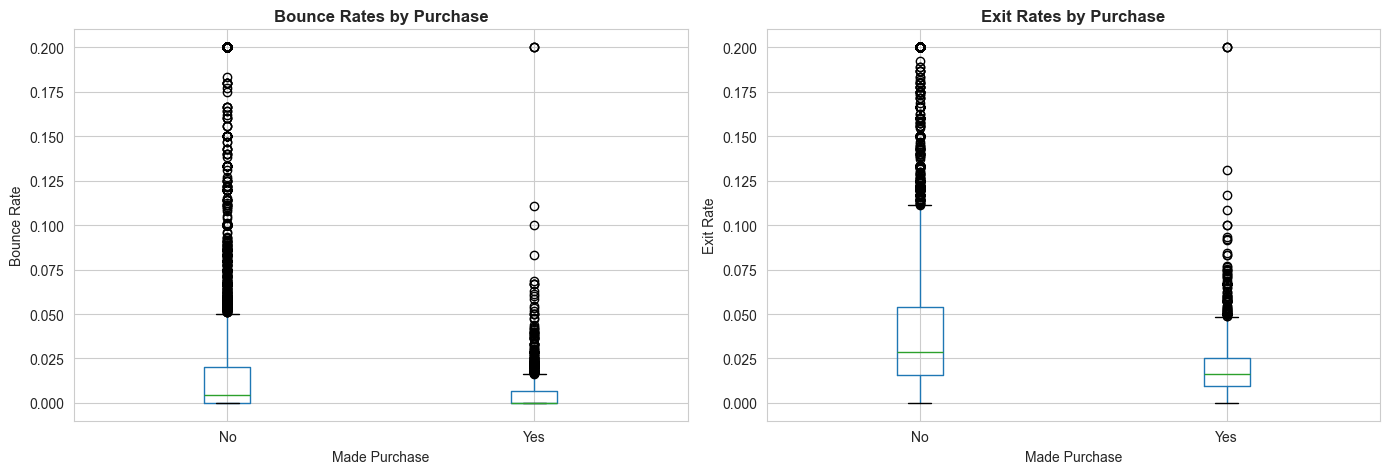

Behavioral metrics by purchase:
         BounceRates  ExitRates  PageValues
Revenue                                    
False       0.025317   0.047378    1.975998
True        0.005117   0.019555   27.264518


In [16]:
# Analyze bounce rates and exit rates
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bounce Rates
df.boxplot(column='BounceRates', by='Revenue', ax=axes[0])
axes[0].set_title('Bounce Rates by Purchase', fontweight='bold', fontsize=12)
axes[0].set_xlabel('Made Purchase')
axes[0].set_ylabel('Bounce Rate')
axes[0].set_xticklabels(['No', 'Yes'])

# Exit Rates
df.boxplot(column='ExitRates', by='Revenue', ax=axes[1])
axes[1].set_title('Exit Rates by Purchase', fontweight='bold', fontsize=12)
axes[1].set_xlabel('Made Purchase')
axes[1].set_ylabel('Exit Rate')
axes[1].set_xticklabels(['No', 'Yes'])

plt.suptitle('')
plt.tight_layout()
plt.show()

print("Behavioral metrics by purchase:")
print(df.groupby('Revenue')[['BounceRates', 'ExitRates', 'PageValues']].mean())

#### EDA - Categorical Features

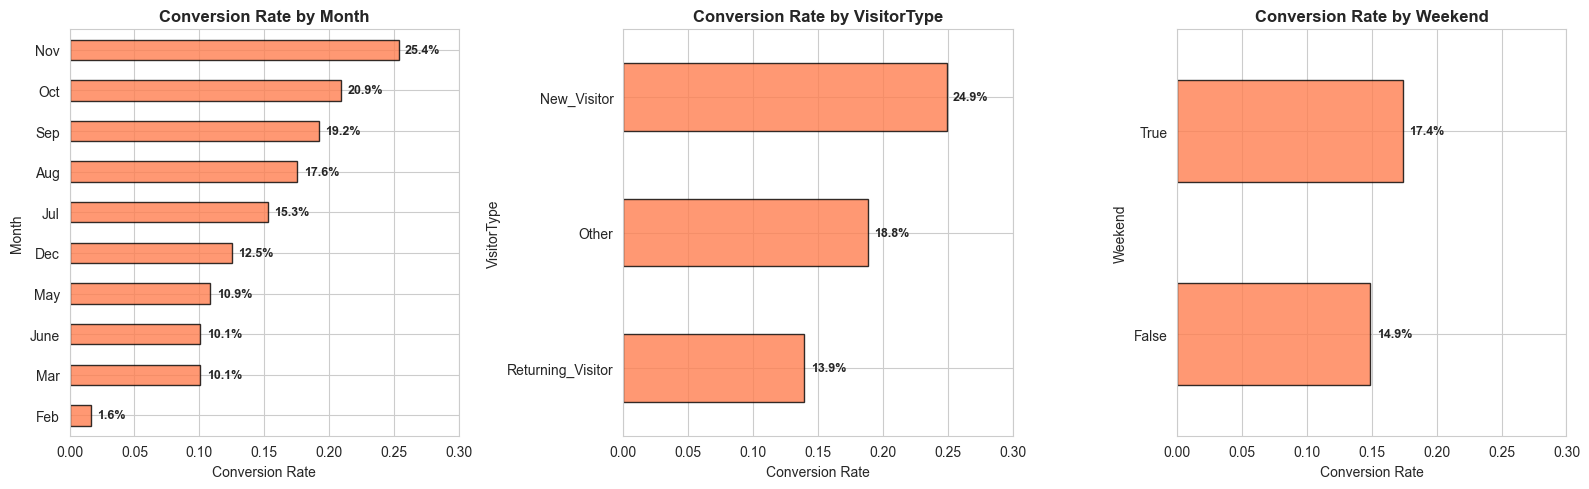


Conversion rates by category:

Month:
       Purchases  Total_Sessions  Conversion_Rate
Month                                            
Aug           76             433           0.1755
Dec          216            1727           0.1251
Feb            3             184           0.0163
Jul           66             432           0.1528
June          29             288           0.1007
Mar          192            1907           0.1007
May          365            3364           0.1085
Nov          760            2998           0.2535
Oct          115             549           0.2095
Sep           86             448           0.1920

VisitorType:
                   Purchases  Total_Sessions  Conversion_Rate
VisitorType                                                  
New_Visitor              422            1694           0.2491
Other                     16              85           0.1882
Returning_Visitor       1470           10551           0.1393

Weekend:
         Purchases  Total_S

In [17]:
categorical_cols = ['Month', 'VisitorType', 'Weekend']

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

for i, col in enumerate(categorical_cols):
    # Conversion rate by category
    conv_rate = df.groupby(col)['Revenue'].mean().sort_values()
    
    conv_rate.plot(kind='barh', ax=axes[i], color='coral', edgecolor='black', alpha=0.8)
    axes[i].set_title(f'Conversion Rate by {col}', fontweight='bold')
    axes[i].set_xlabel('Conversion Rate')
    axes[i].set_xlim(0, 0.3)
    
    # Add percentage labels
    for idx, v in enumerate(conv_rate.values):
        axes[i].text(v + 0.005, idx, f'{v:.1%}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

print("\nConversion rates by category:")
for col in categorical_cols:
    print(f"\n{col}:")
    conv = df.groupby(col)['Revenue'].agg(['sum', 'count', 'mean']).round(4)
    conv.columns = ['Purchases', 'Total_Sessions', 'Conversion_Rate']
    print(conv)

#### EDA - Traffic Sources

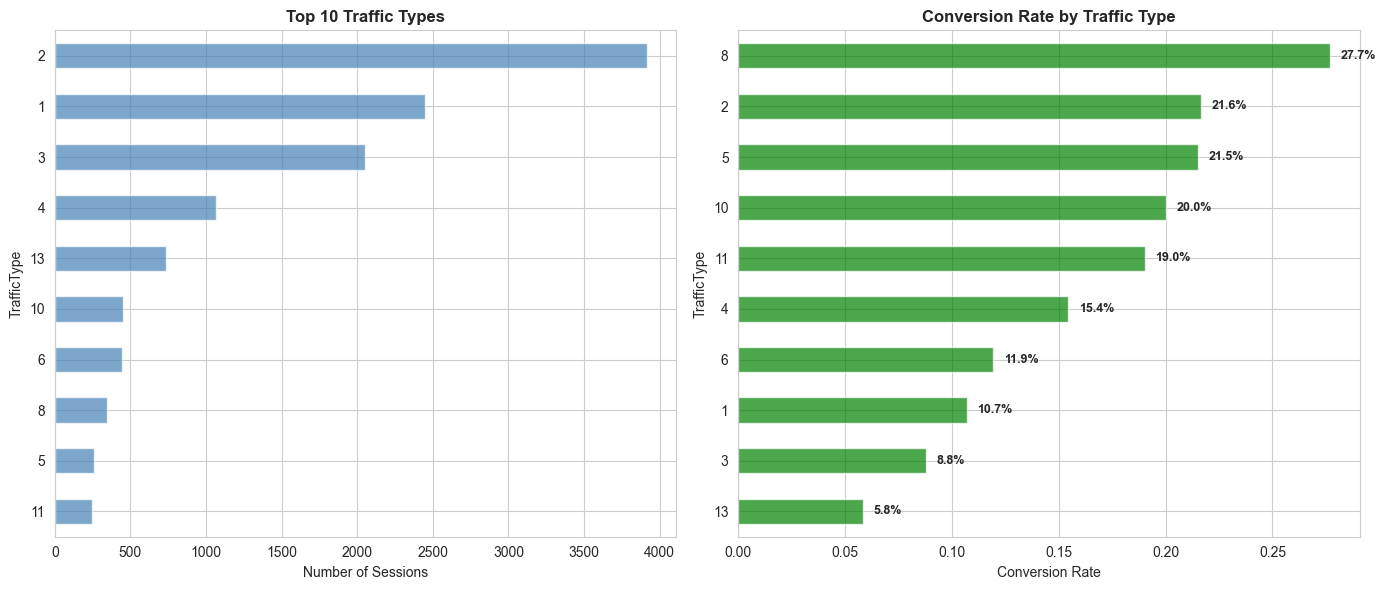

In [18]:
# Analyze traffic type
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Traffic Type distribution
df['TrafficType'].value_counts().head(10).plot(kind='barh', ax=axes[0], 
                                                color='steelblue', alpha=0.7)
axes[0].set_title('Top 10 Traffic Types', fontweight='bold')
axes[0].set_xlabel('Number of Sessions')
axes[0].invert_yaxis()

# Conversion by top traffic types
top_traffic = df['TrafficType'].value_counts().head(10).index
conv_by_traffic = df[df['TrafficType'].isin(top_traffic)].groupby('TrafficType')['Revenue'].mean().sort_values()

conv_by_traffic.plot(kind='barh', ax=axes[1], color='green', alpha=0.7)
axes[1].set_title('Conversion Rate by Traffic Type', fontweight='bold')
axes[1].set_xlabel('Conversion Rate')

for idx, v in enumerate(conv_by_traffic.values):
    axes[1].text(v + 0.005, idx, f'{v:.1%}', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

#### Feature Engineering

In [20]:
# Create new features
print("Creating new features...\n")

# 1. Total pages viewed
df['TotalPages'] = df['Administrative'] + df['Informational'] + df['ProductRelated']

# 2. Total time on site (seconds)
df['TotalDuration'] = (df['Administrative_Duration'] + 
                       df['Informational_Duration'] + 
                       df['ProductRelated_Duration'])

# 3. Average time per page
df['AvgTimePerPage'] = df['TotalDuration'] / (df['TotalPages'] + 1)

# 4. Product page ratio
df['ProductPageRatio'] = df['ProductRelated'] / (df['TotalPages'] + 1)

# 5. Is high value visitor
df['IsHighValueVisitor'] = (df['PageValues'] > df['PageValues'].median()).astype(int)

# 6. Month encoded (shopping season)
# Nov and Dec are holiday shopping months
df['IsHolidaySeason'] = df['Month'].isin(['Nov', 'Dec']).astype(int)

# 7. Engagement score (combination of metrics)
df['EngagementScore'] = (
    (df['TotalPages'] / df['TotalPages'].max()) * 0.3 +
    (df['TotalDuration'] / df['TotalDuration'].max()) * 0.3 +
    ((1 - df['BounceRates']) * 0.2) +
    ((1 - df['ExitRates']) * 0.2)
)

print("\nNew features preview:")
new_features = ['TotalPages', 'TotalDuration', 'AvgTimePerPage', 'ProductPageRatio', 
                'IsHighValueVisitor', 'IsHolidaySeason', 'EngagementScore']
print(df[new_features].describe())

Creating new features...


New features preview:
         TotalPages  TotalDuration  AvgTimePerPage  ProductPageRatio  \
count  12330.000000   12330.000000    12330.000000      12330.000000   
mean      34.550203    1310.037228       34.790387          0.819166   
std       46.514053    2037.801702       33.850108          0.157396   
min        0.000000       0.000000        0.000000          0.000000   
25%        8.000000     222.000000       16.843155          0.750000   
50%       20.000000     680.000000       27.970982          0.870370   
75%       42.000000    1626.908333       43.118423          0.933333   
max      746.000000   69921.647230      940.666667          0.996139   

       IsHighValueVisitor  IsHolidaySeason  EngagementScore  
count        12330.000000     12330.000000     12330.000000  
mean             0.221411         0.383212         0.406462  
std              0.415214         0.486189         0.036520  
min              0.000000         0.000000         0.3

#### Prepare Data

In [21]:
# Prepare for modeling
# Convert target to integer
df['Revenue'] = df['Revenue'].astype(int)

# Drop columns not needed for modeling
X = df.drop(['Revenue'], axis=1)
y = df['Revenue']

print(f"Features: {X.shape[1]}")
print(f"Total samples: {len(X):,}")

# Split: 60% train, 20% validation, 20% test
X_full, X_test, y_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

X_train, X_val, y_train, y_val = train_test_split(
    X_full, y_full, test_size=0.25, random_state=42, stratify=y_full)

print(f"\nTrain: {len(X_train):,} ({len(X_train)/len(df)*100:.1f}%)")
print(f"Validation: {len(X_val):,} ({len(X_val)/len(df)*100:.1f}%)")
print(f"Test: {len(X_test):,} ({len(X_test)/len(df)*100:.1f}%)")

print(f"\nConversion rates:")
print(f"  Train: {y_train.mean():.2%}")
print(f"  Validation: {y_val.mean():.2%}")
print(f"  Test: {y_test.mean():.2%}")


Features: 24
Total samples: 12,330

Train: 7,398 (60.0%)
Validation: 2,466 (20.0%)
Test: 2,466 (20.0%)

Conversion rates:
  Train: 15.48%
  Validation: 15.45%
  Test: 15.49%


#### Feature Encoding

In [23]:
# Encode features with DictVectorizer
train_dicts = X_train.fillna(0).to_dict(orient='records')
val_dicts = X_val.fillna(0).to_dict(orient='records')
test_dicts = X_test.fillna(0).to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_enc = dv.fit_transform(train_dicts)
X_val_enc = dv.transform(val_dicts)
X_test_enc = dv.transform(test_dicts)

print(f"Original features: {X_train.shape[1]}")
print(f"After encoding: {X_train_enc.shape[1]}")

Original features: 24
After encoding: 35


#### Logistic Regression

In [28]:
lr = LogisticRegression(max_iter=1000, random_state=42, solver='liblinear')
lr.fit(X_train_enc, y_train)

y_pred_lr_train = lr.predict_proba(X_train_enc)[:, 1]
y_pred_lr_val = lr.predict_proba(X_val_enc)[:, 1]

lr_train_auc = roc_auc_score(y_train, y_pred_lr_train)
lr_val_auc = roc_auc_score(y_val, y_pred_lr_val)

print(f"Train AUC: {lr_train_auc:.4f}")
print(f"Val AUC:   {lr_val_auc:.4f}")

Train AUC: 0.9140
Val AUC:   0.9172


#### Decision Tree

In [27]:
dt = DecisionTreeClassifier(max_depth=8, min_samples_leaf=50, random_state=42)
dt.fit(X_train_enc, y_train)

y_pred_dt_val = dt.predict_proba(X_val_enc)[:, 1]
dt_val_auc = roc_auc_score(y_val, y_pred_dt_val)

print(f"Val AUC: {dt_val_auc:.4f}")

Val AUC: 0.9208


#### Random Forest

In [29]:
rf = RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=30,
                           random_state=42, n_jobs=-1)
rf.fit(X_train_enc, y_train)

y_pred_rf_val = rf.predict_proba(X_val_enc)[:, 1]
rf_val_auc = roc_auc_score(y_val, y_pred_rf_val)

print(f"Val AUC: {rf_val_auc:.4f}")

Val AUC: 0.9325


#### XGboost

In [30]:
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval = xgb.DMatrix(X_val_enc, label=y_val)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.3,
    'seed': 42
}

xgb_model = xgb.train(xgb_params, dtrain, num_boost_round=100,
                      evals=[(dval, 'val')], verbose_eval=False)

y_pred_xgb_val = xgb_model.predict(dval)
xgb_val_auc = roc_auc_score(y_val, y_pred_xgb_val)

print(f"Val AUC: {xgb_val_auc:.4f}")

Val AUC: 0.9227


#### Model Comparison

              Model  Validation AUC
      Random Forest        0.932497
            XGBoost        0.922694
      Decision Tree        0.920805
Logistic Regression        0.917223


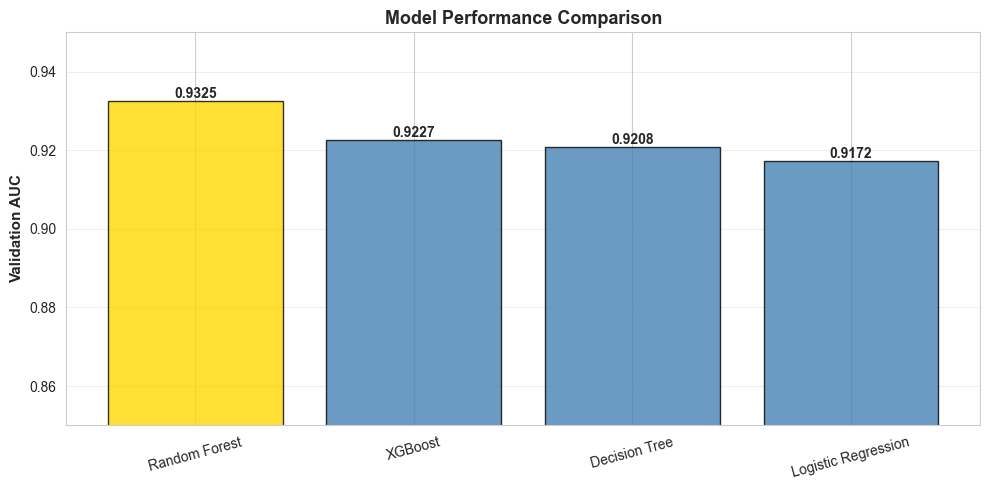

In [33]:
# Compare all models
results = {
    'Logistic Regression': lr_val_auc,
    'Decision Tree': dt_val_auc,
    'Random Forest': rf_val_auc,
    'XGBoost': xgb_val_auc
}

results_df = pd.DataFrame(list(results.items()), columns=['Model', 'Validation AUC'])
results_df = results_df.sort_values('Validation AUC', ascending=False)
print(results_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 5))
colors = ['gold' if i == 0 else 'steelblue' for i in range(len(results_df))]
bars = plt.bar(results_df['Model'], results_df['Validation AUC'], 
               color=colors, edgecolor='black', alpha=0.8)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.ylabel('Validation AUC', fontweight='bold', fontsize=11)
plt.title('Model Performance Comparison', fontweight='bold', fontsize=13)
plt.ylim(0.85, 0.95)
plt.xticks(rotation=15)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

#### Hyperparamater Tuning

In [37]:
best_auc = 0
best_params = {}

print("\nTesting parameters:")
for depth in [4, 6, 8]:
    for eta in [0.1, 0.3, 0.5]:
        params = {
            'objective': 'binary:logistic',
            'eval_metric': 'auc',
            'max_depth': depth,
            'eta': eta,
            'seed': 42
        }
        
        model = xgb.train(params, dtrain, num_boost_round=100,
                         evals=[(dval, 'val')], verbose_eval=False)
        auc = roc_auc_score(y_val, model.predict(dval))
        
        print(f"depth={depth}, eta={eta:.1f} → AUC: {auc:.4f}")
        
        if auc > best_auc:
            best_auc = auc
            best_params = params

print()
print(f"max_depth: {best_params['max_depth']}")
print(f"eta: {best_params['eta']}")
print(f"Best validation AUC: {best_auc:.4f}")



Testing parameters:
depth=4, eta=0.1 → AUC: 0.9330
depth=4, eta=0.3 → AUC: 0.9229
depth=4, eta=0.5 → AUC: 0.9195
depth=6, eta=0.1 → AUC: 0.9329
depth=6, eta=0.3 → AUC: 0.9227
depth=6, eta=0.5 → AUC: 0.9244
depth=8, eta=0.1 → AUC: 0.9270
depth=8, eta=0.3 → AUC: 0.9201
depth=8, eta=0.5 → AUC: 0.9202

max_depth: 4
eta: 0.1
Best validation AUC: 0.9330


#### Train Final Model

In [39]:
X_full_enc = np.vstack([X_train_enc, X_val_enc])
y_full_all = np.concatenate([y_train, y_val])

dfull = xgb.DMatrix(X_full_enc, label=y_full_all)
dtest = xgb.DMatrix(X_test_enc, label=y_test)

final_model = xgb.train(best_params, dfull, num_boost_round=100)

# Evaluate on test set
y_pred_test = final_model.predict(dtest)
test_auc = roc_auc_score(y_test, y_pred_test)

y_pred_class = (y_pred_test >= 0.5).astype(int)
test_acc = accuracy_score(y_test, y_pred_class)

print(f"AUC:       {test_auc:.4f}")
print(f"Accuracy:  {test_acc:.4f}")
print(f"Precision: {precision_score(y_test, y_pred_class):.4f}")
print(f"Recall:    {recall_score(y_test, y_pred_class):.4f}")
print(f"F1-Score:  {f1_score(y_test, y_pred_class):.4f}")

print()
print(classification_report(y_test, y_pred_class, 
                          target_names=['No Purchase', 'Purchase']))

AUC:       0.9316
Accuracy:  0.9027
Precision: 0.7290
Recall:    0.5916
F1-Score:  0.6532

              precision    recall  f1-score   support

 No Purchase       0.93      0.96      0.94      2084
    Purchase       0.73      0.59      0.65       382

    accuracy                           0.90      2466
   macro avg       0.83      0.78      0.80      2466
weighted avg       0.90      0.90      0.90      2466



#### Confusion Matrix

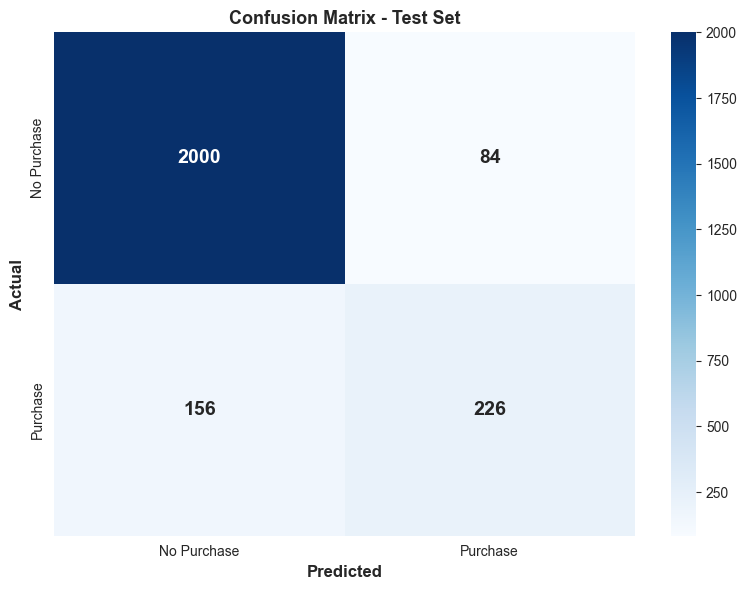

True Negatives (Correct No Purchase):  2,000
False Positives (Predicted Purchase):  84
False Negatives (Missed Purchases):    156
True Positives (Correct Purchase):     226


In [41]:
cm = confusion_matrix(y_test, y_pred_class)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Purchase', 'Purchase'], 
            yticklabels=['No Purchase', 'Purchase'],
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix - Test Set', fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"True Negatives (Correct No Purchase):  {cm[0,0]:,}")
print(f"False Positives (Predicted Purchase):  {cm[0,1]:,}")
print(f"False Negatives (Missed Purchases):    {cm[1,0]:,}")
print(f"True Positives (Correct Purchase):     {cm[1,1]:,}")

#### ROC Curve

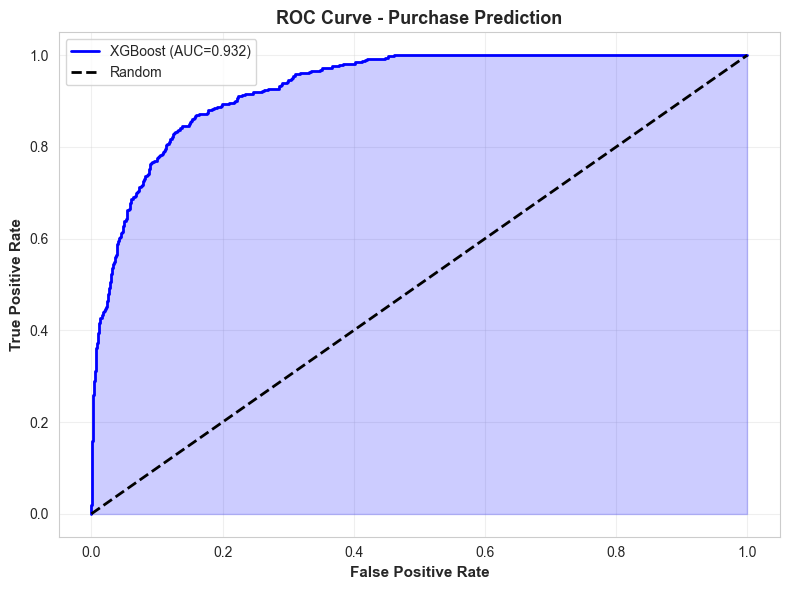

In [42]:
fpr, tpr, _ = roc_curve(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, linewidth=2, color='blue', label=f'XGBoost (AUC={test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random')
plt.fill_between(fpr, tpr, alpha=0.2, color='blue')
plt.xlabel('False Positive Rate', fontsize=11, fontweight='bold')
plt.ylabel('True Positive Rate', fontsize=11, fontweight='bold')
plt.title('ROC Curve - Purchase Prediction', fontsize=13, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

#### Feature Importance

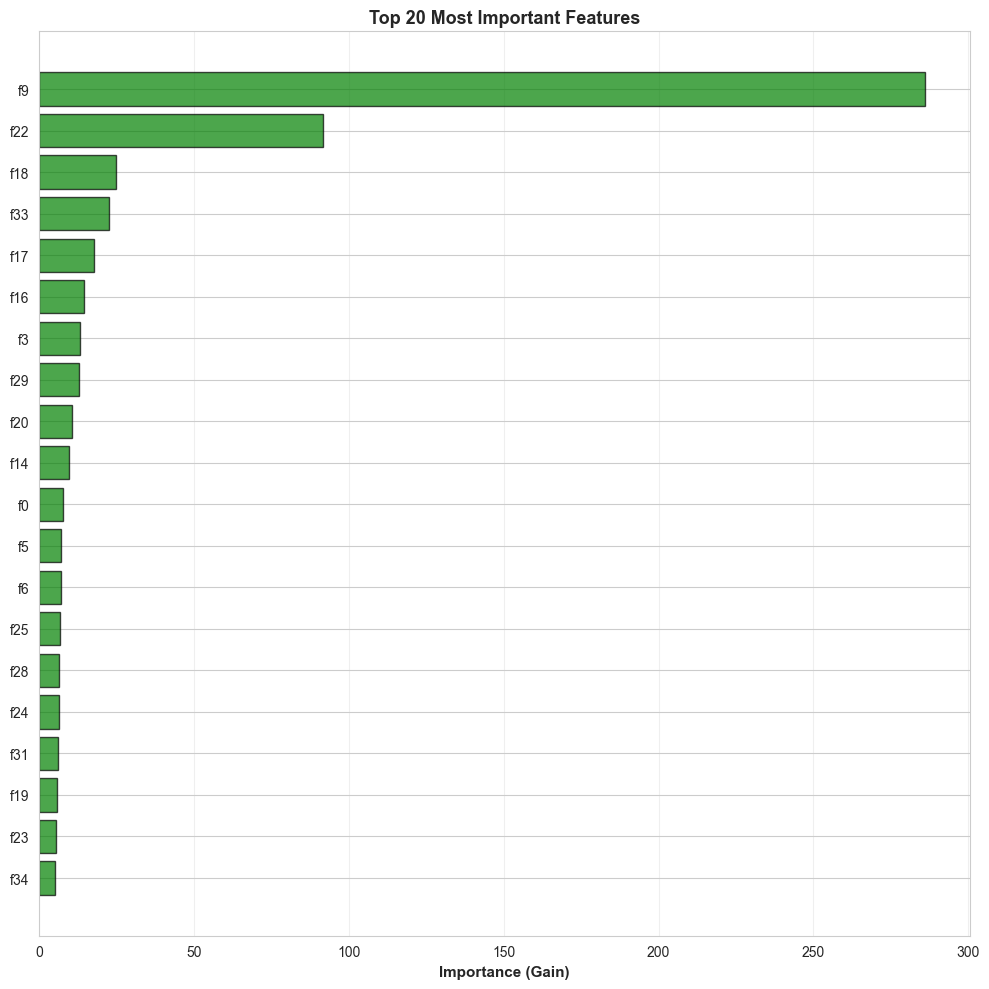

feature  importance
     f9  286.133362
    f22   91.512184
    f18   24.800783
    f33   22.456675
    f17   17.738178
    f16   14.300678
     f3   13.223005
    f29   12.750383
    f20   10.575795
    f14    9.504863
     f0    7.630864
     f5    6.914571
     f6    6.878781
    f25    6.858804
    f28    6.316772


In [44]:
importance = final_model.get_score(importance_type='gain')
importance_df = pd.DataFrame({
    'feature': list(importance.keys()),
    'importance': list(importance.values())
}).sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(10, 10))
plt.barh(importance_df['feature'], importance_df['importance'], 
         color='green', alpha=0.7, edgecolor='black')
plt.xlabel('Importance (Gain)', fontsize=11, fontweight='bold')
plt.title('Top 20 Most Important Features', fontsize=13, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(importance_df.head(15).to_string(index=False))

#### Save Model

In [45]:
final_model.save_model('model.bin')

with open('dv.pkl', 'wb') as f:
    pickle.dump(dv, f)